In [1]:
from gpu_info import print_system_info, print_gpu_info
# 执行函数
print_system_info()
print_gpu_info()
%load_ext autoreload
%autoreload 2

=== CPU Information ===
CPU: x86_64 | Physical cores: 64 | Total cores: 128 | CPU Usage: 6.7%
Memory - Total: 503.56 GB | Available: 483.77 GB | Usage: 3.9%
=== GPU Information ===
Found 4 CUDA devices
GPU 0: NVIDIA A800-SXM4-80GB | Total Memory: 81228.81 MB | Free: 65006.62 MB | Used: 16222.19 MB | Usage: 20.0%
GPU 1: NVIDIA A800-SXM4-80GB | Total Memory: 81228.81 MB | Free: 64982.62 MB | Used: 16246.19 MB | Usage: 20.0%
GPU 2: NVIDIA A800-SXM4-80GB | Total Memory: 81228.81 MB | Free: 64982.62 MB | Used: 16246.19 MB | Usage: 20.0%
GPU 3: NVIDIA A800-SXM4-80GB | Total Memory: 81228.81 MB | Free: 64994.62 MB | Used: 16234.19 MB | Usage: 20.0%


In [2]:
import torch
from compel import Compel
from models.CustomSD import CustomSDPipeline
from models.StageUnclip import StageStableUnCLIPImg2ImgPipeline
from experiments.util import change_UNet

base_model_id = "./pretrained/stable-diffusion-2-1"
unclip_model_id = "./pretrained/stable-diffusion-2-1-unclip"
# Constants
DEFAULT_GPU = 2
DEFAULT_STEPS = 45
DEFAULT_GUIDANCE_SCALE = 4.0

gpu_idx = DEFAULT_GPU

# Setup device
device = torch.device(f"cuda:{gpu_idx}" if torch.cuda.is_available() and gpu_idx >= 0 else "cpu")

pipeline = CustomSDPipeline.from_pretrained(base_model_id, 
                                            torch_dtype=torch.float32, 
                                            safe_checker=None).to(device)

stage_pipe = StageStableUnCLIPImg2ImgPipeline.from_pretrained(unclip_model_id,
                                            torch_dtype=torch.float32,
                                            safety_checker=None).to(device)

compel_proc = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

change_UNet(pipeline, gpu_idx)
change_UNet(stage_pipe, gpu_idx)

/home/hwang/miniconda3/envs/Z/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Keyword arguments {'safe_checker': None} are not expected by CustomSDPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]
/home/hwang/miniconda3/envs/Z/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Keyword arguments {'safety_checker': None} are not expected by StageStableUnCLIPImg2ImgPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 9/9 [00:00<00:00, 14.11it/s]


In [38]:
class1 = "dog"
class2 = "cat"
gamma_list = [1,1]
DEFAULT_STEPS = 35
DEFAULT_GUIDANCE_SCALE = 7.5
# 生成图像的参数
assistant_prompt = "natural light, 8k"

# image1_path = "/projects/zhouyufan/Projects/DE/blend_concept/img_v1.jpg"
# image2_path = "/projects/zhouyufan/Projects/DE/blend_concept/img_v3.jpg"
image1_path = None
image2_path = None

prompt1 = f"A photo of a {class1} with {assistant_prompt}"  # 第一个概念
prompt2 = f"A photo of a {class2} with {assistant_prompt}"  # 第二个概念

Using random seed: 1736950121; dog and cat


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


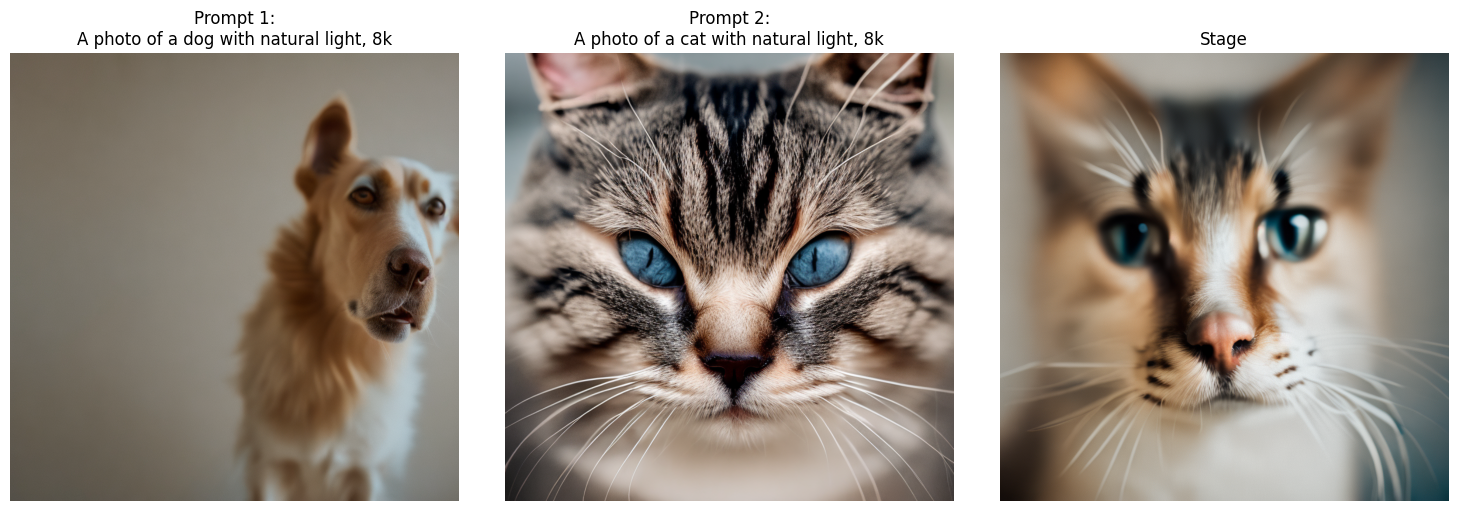

In [47]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
from experiments.util import set_random_seed
import numpy as np

steps = DEFAULT_STEPS
guidance_scale = DEFAULT_GUIDANCE_SCALE

# 每次生成时，使用新的随机种子
seed = set_random_seed()  # 生成并设置新的随机种子

# 输出当前的随机种子（用于调试或记录）
print(f"Using random seed: {seed}; {class1} and {class2}")

# 生成 embedding
embedding1 = compel_proc(prompt1)
embedding2 = compel_proc(prompt2)

# 生成图像
if image1_path is None:
    image1 = pipeline(
        prompt_embeds=embedding1,
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
    ).images[0]
else:
    image1 = Image.open(image1_path).convert("RGB")

if image2_path is None:
    image2 = pipeline(
        prompt_embeds=embedding2,
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
    ).images[0]
else:
    image2 = Image.open(image2_path).convert("RGB")
    
# stage
stage_image = stage_pipe(
    image_list=[image1, image2],
    prompt_embeds_list=[embedding1, embedding2],
    num_inference_steps=steps - 1, 
    guidance_scale=guidance_scale,
    t_start=0.1,
    t_end=0.9,
    gamma=gamma_list
    ).images[0]

stage_image = stage_image.resize(image1.size)

# Create folder name with current timestamp
folder_name = datetime.now().strftime('%m%d_%H%M')
save_dir = os.path.join('generated_images', str(seed)+'_'+folder_name+'_'+class1+'_'+class2)

# Create new folder
os.makedirs(save_dir, exist_ok=True)

# Create image list and save images
image_list = [image1, image2, stage_image]

image1.save(os.path.join(save_dir, f'image_1.png'))
image2.save(os.path.join(save_dir, f'image_2.png'))
stage_image.save(os.path.join(save_dir, f'image_stage.png'))
    
titles = [
    f'Prompt 1:\n{prompt1}',
    f'Prompt 2:\n{prompt2}',
    'Stage'
]
# 创建图形窗口并设置子图
fig, axes = plt.subplots(1, 3, figsize=(5*3, 5*1))  # 修改为4列，包含四张图
axes = axes.flatten()  # 将2D数组展平为1D数组

# 设置每个子图的标题和显示内容
for idx, (ax, img, title) in enumerate(zip(
    axes,
    image_list,
    titles
)):
    # 将PIL图像转换为numpy数组
    img_array = np.array(img)
    ax.imshow(img_array)
    ax.set_title(title)
    ax.axis('off')  # 不显示坐标轴

# 调整布局以避免重叠
plt.tight_layout()

# 显示图像
plt.show()

In [48]:
!rm -rf generated_images/*